In [0]:
from twython import Twython

# Set up ability to tweet
# Consumer key and access token are provided by registering an application with Twitter.
consumer_key        = ''
consumer_secret     = ''
access_token        = ''
access_token_secret = ''

twitter = Twython(
    consumer_key,
    consumer_secret,
    access_token,
    access_token_secret
)


# Detect Game Start

In [0]:
import datetime 

# get current date
today = datetime.date.today().strftime("%Y-%m-%d")
tommorrow = ( datetime.date.today() + datetime.timedelta(days=2)).strftime("%Y-%m-%d")


To detect a game start, we use a moving threshold based on the number of tweets mentioning 'nfl' that also include a word related to the beginning of a game, such as 'kickoff'.

In [4]:
import numpy as np
import time
from sklearn.feature_extraction.text import CountVectorizer
from Tweet import Tweet
from TweetCriteria import TweetCriteria
from TweetManager import TweetManager 


# words related to game start
game_start_words = ['started', 'starts', 'begins', 'begin', 'began', 'begun', 'beginning', 'kickoff']
vectorizer = CountVectorizer()
vectorizer.fit(game_start_words)

tweet_volume = [] # stores number of relevant tweets / minute
while(True):
    ti = datetime.datetime.now()
    # get recent tweets mentioning nfl
    tweetCriteria = TweetCriteria().setQuerySearch('nfl').setSince(today).setUntil(tommorrow).setMaxTweets(1200)
    tweets = TweetManager().getTweets(tweetCriteria)

    # find tweets from the last minute
    cur_tweets = []
    for t in tweets:
        if t.date + datetime.timedelta(minutes=1)  > ti:
            cur_tweets.append(t.text)
    
    # count tweets that mention a start word
    counts = np.sum(vectorizer.transform(cur_tweets).toarray())
    tweet_volume.append(counts)
    # calculate threshold
    m = np.mean(tweet_volume)
    s = np.sqrt(np.var(tweet_volume))
    thresh = m + 2*s 
    if counts > thresh:
        # game starts when tweet volume exceeds threshold
        print("game detected")
        print(ti)
        break

    # sleep until next minute
    sec = (ti + datetime.timedelta(minutes=1) - datetime.datetime.now()).total_seconds()
    if sec > 0:
        time.sleep(sec)
    
    






game detected
2020-01-13 00:06:01.379993


# Identify Game Hashtags

## Identify Teams

We look at the top mentions of nfl team names among the lastest tweets to identify the teams in the game

In [22]:
# identify teams

latest_tweets = tweets

team_names = ['patriots', 'rams', 'chargers', 'broncos', 'cowboys', 
              '49ers', 'giants', 'eagles', 'bears', 'colts', 'jets',
             'steelers', 'ravens', 'panthers', 'vikings', 'bills', 
             'packers', 'saints', 'browns', 'falcons', 'cardinals',
             'chiefs', 'buccaneers', 'redskins', 'texans', 'seahawks',
             'dolphins', 'bengals', 'jaguars', 'titans', 'raiders', 'lions']

# find team name mentions
name_vectorizer = CountVectorizer()
name_vectorizer.fit(team_names)
names = name_vectorizer.get_feature_names()

# extract text of tweets
latest_text = []
num_tweets = len(latest_tweets)
for i in range(num_tweets):
    if np.sum(vectorizer.transform([latest_tweets[i].text])) != 0:
      latest_text.append(latest_tweets[i].text)

 # count team name mentions
counts = name_vectorizer.transform(latest_text)
count_by_team = np.sum(counts.toarray(), axis=0)
top2 = np.argsort(count_by_team)[::-1][0:2] # top teams

# Find top team names
team_A = names[top2[0]]
team_B = names[top2[1]]

message = team_A.capitalize() + " vs " + team_B.capitalize() + " starting now!"

print(message)


Seahawks vs Packers starting now!


## Get Hashtags

We get the top 20 hastags used in mentions of 'nfl', and then count team name mentions for each hashtag to determine if each hashtag is associated with a certain team, or is a neutral game hashtag

In [0]:
# returns the top k hashtags in a set of tweets
# and a dictionary of tweets organized by hashtag  
def getTopHashtags(tweets, k):
    hashtags = {}
    idx = 0
    for tweet in tweets:
        if tweet.hashtags == "":
            continue
        htgs = set(tweet.hashtags.split(" "))
        for htg in htgs:
            htg = htg.lower()
            if htg in hashtags:
                hashtags[htg] += 1
            else:
                hashtags[htg] = 1
        idx += 1
    
    sorted_hashtags = sorted(hashtags, key=hashtags.get, reverse=True)
    topk = sorted_hashtags[0:k]
    
    return topk

In [0]:
# gets tweets mentioning team A
tweetCriteria = TweetCriteria().setQuerySearch(team_A).setSince(today).setUntil(tommorrow).setMaxTweets(1000)
tweetsA = TweetManager.getTweets(tweetCriteria)

# get tweets mentioning team B
tweetCriteria = TweetCriteria().setQuerySearch(team_B).setSince(today).setUntil(tommorrow).setMaxTweets(1000)
tweetsB = TweetManager.getTweets(tweetCriteria)

In [17]:

# get most popular hashtags 
k = 20
topk = getTopHashtags(latest_tweets, k)

htg_by_team = {} # counts of team mentions per hastag
for htg in topk:
    htg_by_team[htg] = [0,0]
# count mentions of team A in each hashtag
for t in tweetsA:
    if t.hashtags == "":
        continue
    htgs = set(t.hashtags.split(" "))
    for htg in htgs:
        htg = htg.lower()
        if htg in htg_by_team:
            htg_by_team[htg][0] += 1
# count mentions of team B in each hashtag
for t in tweetsB:
    if t.hashtags == "":
        continue
    htgs = set(t.hashtags.split(" "))
    for htg in htgs:
        htg = htg.lower()
        if htg in htg_by_team:
            htg_by_team[htg][1] += 1

# calculate Team A/Team B usage split for each hastag
#  to find team and neutral hashtags
teamAhtgs = {}
teamBhtgs = {}
neutralhtgs = {}
for h in htg_by_team:
    total = htg_by_team[h][0] + htg_by_team[h][1]
    if total == 0:
        continue
    frac = htg_by_team[h][0] / (1.0 * total) # % team mentions are team A
    # identify team hashtags using cutoff of 70% for % of mentions
    if frac > 0.7:
        teamAhtgs[h] = total
    elif frac < 0.3:
        teamBhtgs[h] = total
    else:
        neutralhtgs[h] = total

def dict_sort(d):
    s = sorted(d, key=d.get, reverse=True)
    return s

# get top hashtags
sorted_A = dict_sort(teamAhtgs)
sorted_B = dict_sort(teamBhtgs)
sorted_G = dict_sort(neutralhtgs)

htA = sorted_A[0:2]
htB = sorted_B[0:2]
htG = sorted_G[0:2]
    
print("\nTeam A:")
print(htA)
print("\nTeam B:")
print(htB)
print("\nGame:")
print(htG)


Team A:
['#packers', '#gopackgo']

Team B:
['#seahawks']

Game:
['#seavsgb', '#nflplayoffs']


# Generate Tweet Summary

## Model Definition

The model we use is an RNN

In [9]:
# Generate tweets about the events
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from __future__ import absolute_import, division, print_function
import tensorflow as tf
import time
import functools

tf.get_logger().setLevel('WARNING')
tf.logging.set_verbosity(tf.logging.ERROR) 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) 

seq_length = 50

tf.enable_eager_execution()

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

rnn = functools.partial(tf.keras.layers.GRU, recurrent_activation='sigmoid')
def build_model(num_chars, batch_size=32):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_chars, 256, 
                              batch_input_shape=[batch_size, None]),
        rnn(1024,
            return_sequences=True, 
            recurrent_initializer='glorot_uniform',
            stateful=True),
        tf.keras.layers.Dense(num_chars)
      ])
    return model

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)


In [0]:
def generate_text(model, start_string, char2idx, temperature = 1.0, num_generate = 1000):
    idx2char = np.array(chars)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))



## Train Model

We train the RNN using tweets from the last minute after a detected event. Distinct tweets are distinguished using a newline character.

In [0]:
import numpy as np

def train(tweets):
    corpus = ''
    for tweet in tweets:
        corpus += tweet + '\n'
    chars = sorted(set(corpus))
    char2idx = {u:i for i, u in enumerate(chars)}
    idx2char = np.array(chars)

    text_as_int = np.array([char2idx[c] for c in corpus])
    examples_per_epoch = len(corpus)//seq_length
    char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
    sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
    dataset = sequences.map(split_input_target)
    dataset = dataset.shuffle(10000).batch(32, drop_remainder=True)
    steps_per_epoch = examples_per_epoch//32

    model = build_model(
      num_chars = len(chars))

    model.compile(
      optimizer = tf.train.AdamOptimizer(),
      loss = loss)

    history = model.fit(dataset.repeat(), epochs=100, steps_per_epoch=steps_per_epoch, verbose=0)
    model.save_weights('weights.hd5')

    model = build_model(len(chars), batch_size=1)
    model.load_weights('weights.hd5')
    model.build(tf.TensorShape([1, None]))

    start_string = "\n" 
    temperature = 1.0
    num_generate = 2400
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))


## Tweet

We use the RNN to generate multiple tweets. Then we assign each tweet a quality score and pick the best one to tweet. The quality score is based on the relevance of words in the training corpus.  

In [0]:
# Generate ~20 tweets
import re

def gen_tweet(tweets):
    # train model & generate tweets
    tweets_cleaned = []
    for tweet in tweets:
    words = tweet.split(' ')
    # clean tweets by removing links
    cleaned_t = ''
    for w in words:
        if 'twitter.com' in w:
            continue
        cleaned_t += w + ' '
    tweets_cleaned.append(cleaned_t)

    new_tweets = train(tweets_cleaned)

    # Assess quality of tweets and pick the best

    # counts of words in original tweets
    sw = ['the', 'and', 'of', 'a', 'it', 'on', 'at', 'lol', 'is', 'to', 'im', 'my', 'oh', 'this', 'thats']
    cv = CountVectorizer(stop_words=sw)

    counts = cv.fit_transform(tweets).toarray()
    num_words = counts.shape[1]

    # counts of words in new tweets
    generated_tweets = new_tweets.split('\n')
    counts_generated = cv.transform(generated_tweets).toarray()
    num_tweets = len(generated_tweets)

    # find the best tweet
    best_score = 0
    best_tweet_idx = 0
    for i in range(num_tweets):
        t = generated_tweets[i]
        if len(t) < 2:
            continue
        if 'twitter.com' in t:
            continue
        total = 0
        for j in range(num_words):
            if counts_generated[i,j] != 0:
                total +=  np.sum(counts[:, j])
        real_words = False
        words = t.split(" ")
        n = 0
        for w in words:
            if w not in sw:
                n += 1
            if len(w) > 0:
                if w[0] != '#':
                    real_words = True
        if not real_words:
            continue
        quality_score = total / n * np.log(np.sum(counts_generated[i,:]))
        # give preference to tweets with game scores
        if re.match('.*[0-9]\-[0-9].*', t):
            quality_score += 100

        if quality_score > best_score:
            best_score = quality_score
            best_tweet_idx = i
    
    message = generated_tweets[best_tweet_idx]

    # send tweet
    twitter.update_status(status=message)
    print("Tweeted: \n" + message)
    return new_tweets


# Detect Events

We use moving threshold detection to detect significant game events based on the volume of tweets using the game hashtag each minute.

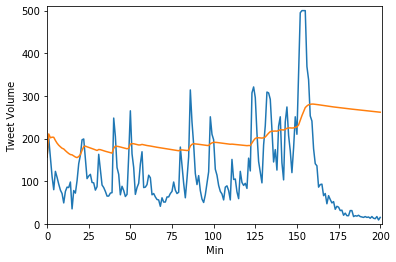

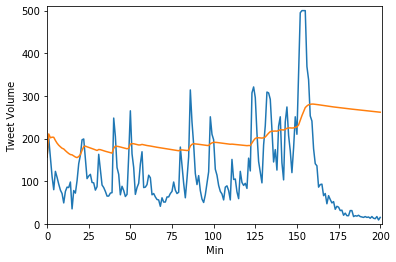

In [18]:

import matplotlib.pyplot as plt
import threading

def _removeNonAscii(s): return "".join(i for i in s if ord(i)<128)


fig,ax = plt.subplots(1,1)
ax.set_xlabel('Min')
ax.set_ylabel('Tweet Volume')
ax.plot([],[],'C0')
ax.plot([],[],'C1')

# count tweet volume during each minute of game
gamehtg = htG[0]
tweet_volume = []
thresholds = []
TS = []
event = False
most_tweets = 0
ts = 0 # game minute. runs for 200 minutes
while(ts <= 200):
    ti = datetime.datetime.now()
    # get recent tweets using game hashtag
    tweetCriteria = TweetCriteria().setQuerySearch(gamehtg).setSince(today).setUntil(tommorrow).setMaxTweets(500)
    twts = TweetManager.getTweets(tweetCriteria)

    # count tweets in last minute
    ntweets = 0 
    for t in twts:
        if t.date + datetime.timedelta(minutes=1) > ti:
            ntweets += 1
    tweet_volume.append(ntweets)  
    if ntweets > most_tweets:
        most_tweets = ntweets

    # calculate moving threshold
    m = np.mean(tweet_volume)
    s = np.sqrt(np.var(tweet_volume))
    thresh = m + 1.5*s
    thresholds.append(thresh)

    # detect events
    if ntweets > thresh and not event:
        print("Detected Event")
        event = True
        
        tweets = []
        for t in twts:
            if t.date + datetime.timedelta(minutes=2) > ti:
                tweets.append(_removeNonAscii(t.text))
        t1 = threading.Thread(target=gen_tweet, args=(tweets,))
        t1.start()
       
    if ntweets < thresh:
        event = False

    # plot
    TS.append(ts)
    ax.lines[0].set_xdata(TS)
    ax.lines[0].set_ydata(tweet_volume)
    ax.lines[1].set_ydata(thresholds)
    ax.lines[1].set_xdata(TS)
    ax.set_xlim(0,ts+1)
    ax.set_ylim(0,most_tweets+10)
    display.clear_output()
    display.display(pl.gcf())
    fig.canvas.draw()

    ts += 1

    # sleep until next minute
    sec = (ti + datetime.timedelta(minutes=1) - datetime.datetime.now()).total_seconds()
    if sec > 0:
        time.sleep(sec)


In [0]:
# Restart the notebook and run again
from IPython.core.display import HTML
from IPython.display import Javascript

HTML("<script>Jupyter.notebook.kernel.restart()</script>")
Javascript("Jupyter.notebook.execute_cells([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])")